In [37]:
from scipy.signal import savgol_filter
from forced_convection_dft.find_incident_heat_flux import HeatFluxFinder
from dft_inverse_code import dft_models, heat_transfer_coefficients
from forced_convection_dft.forward_models import ForwardModelDft, ForwardModelThermocouple
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
import pandas as pd
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 4
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
data_fan = pd.read_csv('../data/dft_fan.csv', skiprows=[1])
data_no_fan = pd.read_csv('../data/dft_no_fan.csv', skiprows=[1])

n_points = data_fan.shape[0]
time_vec = np.linspace(0, 0.5 * n_points, n_points)
temp_front = data_fan['CH1'].to_numpy()
temp_back = data_fan['CH2'].to_numpy()
temp_tc = data_fan['CH3'].to_numpy()
constant = 273.15

temp_front_no_fan = data_no_fan['CH1'].to_numpy()
temp_back_no_fan = data_no_fan['CH2'].to_numpy()
time_vec_no_fan = np.linspace(0, 0.5 * data_no_fan.shape[0], data_no_fan.shape[0])


In [39]:
diameter_tc = 1.4e-3
density_tc = 8665
heat_capacity_tc = 485.6 
emissivity_tc = 0.8
alpha_tc = 0.8
dft_thickness =  0.0016
insulation_thickness = .019
plate_side_length = .0762

In [40]:
temp_init = 21 + constant
temp_surr = 21 + constant
temp_amb = 21 + constant

In [41]:
time_vec_model = time_vec.copy()

In [42]:
q_inc = np.ones_like(time_vec_model) * 10e3
q_inc[time_vec_model < 3 * 60] = 0
q_inc[time_vec_model > 8 * 60] = 0

In [43]:
velocity = np.ones(len(time_vec_model)) * 4.5
forward_dft = ForwardModelDft(n_nodes=20, time=time_vec_model, insul_thickness=insulation_thickness, plate_thickness=dft_thickness, q_inc=q_inc,
                 characteristic_velocity=velocity, temp_init=temp_init, temp_amb=temp_amb, temp_surr=temp_surr, dft_plate_length=plate_side_length)
temp_f_model, temp_b_model, temp_ins, h_f, h_b = forward_dft.run()
forward_tc = ForwardModelThermocouple(time_vec, q_inc, velocity, temp_init,
                 temp_amb, temp_surr, emissivity_tc, alpha_tc, diameter_tc, heat_capacity_tc,
                 density_tc)
temp_tc_model = forward_tc.run()

100%|██████████| 1205/1205 [00:00<00:00, 13999.37it/s]


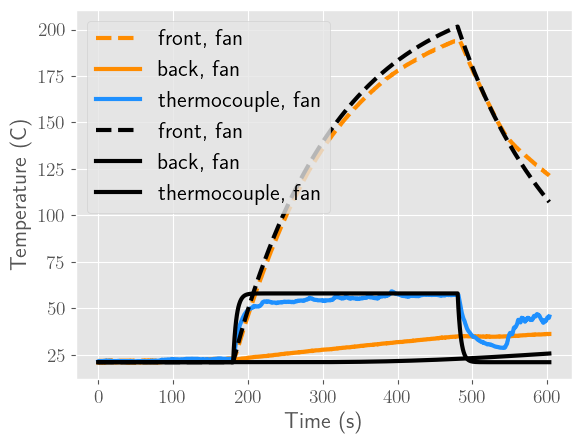

In [44]:
plt.plot(time_vec, temp_front, label='front, fan', lw=3, color='darkorange', linestyle='--')
plt.plot(time_vec, temp_back, label='back, fan', lw=3, color='darkorange')
#plt.plot(time_vec_no_fan, temp_front_no_fan, label='front, no fan', lw=3, color='red', linestyle='--')
#plt.plot(time_vec_no_fan, temp_back_no_fan, label='back, no fan', lw=3, color='red')
plt.plot(time_vec, temp_tc, label='thermocouple, fan', lw=3, color='dodgerblue')
#plt.plot(time_vec_model, temp_ins - constant,  lw=3, color='green')

plt.plot(time_vec_model, temp_f_model - constant, label='front, fan', lw=3, color='black', linestyle='--')
plt.plot(time_vec_model, temp_b_model - constant, label='back, fan', lw=3, color='black')
plt.plot(time_vec, temp_tc_model - constant, label='thermocouple, fan', lw=3, color='black')

plt.xlabel('Time (s)')
plt.legend()
plt.ylabel('Temperature (C)');

# Recover heat flux

array([6.12454353])

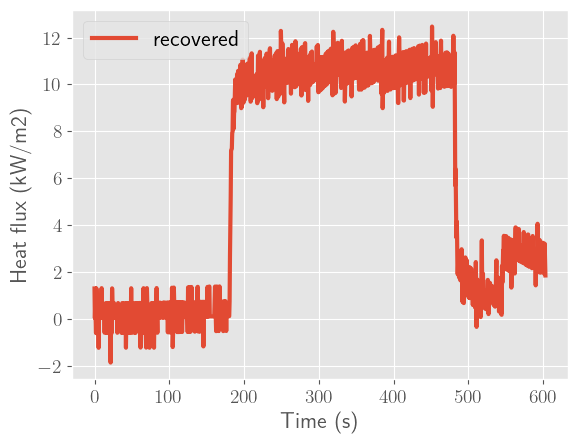

In [45]:
hf_finder = HeatFluxFinder(temp_front + constant, temp_back + constant, temp_tc + constant, temp_amb,
                   temp_init, temp_surr, time_vec, diameter_tc,
                   alpha_tc, alpha_tc, heat_capacity_tc, density_tc, 
                           constant_velocity=True,  
                           plate_side_length=plate_side_length)
#plt.plot(time_vec, q_inc / 1e3, lw=3, label='prescribed')
plt.plot(time_vec, hf_finder.find_q_inc(), lw=3, label='recovered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');
hf_finder.velocity

In [46]:
h_f_nat = heat_transfer_coefficients.natural_convection(
            (temp_front + constant + temp_amb).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=temp_amb).custom(0.65, 0.25).flatten()

h_b_nat = heat_transfer_coefficients.natural_convection(
            (temp_back + constant + temp_amb).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=temp_amb).custom(0.65, 0.25).flatten()

In [47]:
q_inc_plate = dft_models.one_dim_conduction(T_f=temp_front + constant, T_b=temp_back + constant, time=time_vec, h_f=h_f_nat, h_b=h_b_nat, model='one_d_conduction', Kelvin=True, T_inf=temp_amb, T_sur=temp_surr).q_inc


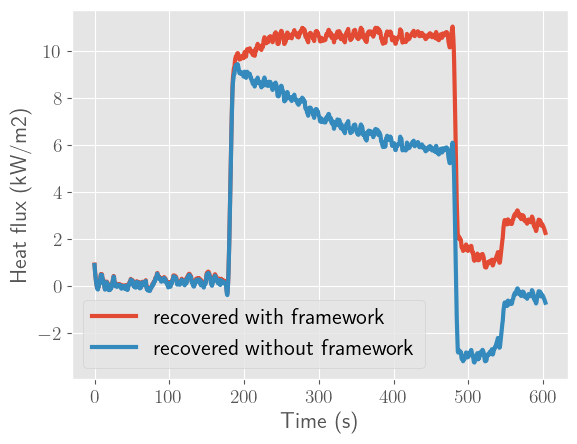

In [48]:
plt.plot(time_vec, savgol_filter(hf_finder.find_q_inc(), 20, 2), lw=3, label='recovered with framework')
plt.plot(time_vec, savgol_filter(q_inc_plate, 20, 2), lw=3, label='recovered without framework')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');